In [1]:
%matplotlib inline
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from PIL import Image
import glob, os
from glob import glob
import matplotlib.pyplot as plt

import torchvision
from torchvision import datasets
import torchvision.transforms as transforms

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

#pip install torchsummary
from torchsummary import summary

In [2]:
# check if CUDA is available
use_cuda = torch.cuda.is_available()
print(use_cuda)

False


In [3]:
data_dir = ''

In [4]:
# Verification of the number of Images 

# load filenames for human and dog images
size = 0
size = np.array(glob(data_dir+"images/*"))

# Check one image
#Image.open(open("/kaggle/input/plant-pathology-2020-fgvc7/images/Train_3.jpg", 'rb'))

# print number of images in each dataset
print('There are %d total images.' % len(size))

sample_csv = pd.read_csv(data_dir + 'sample_submission.csv')
test_csv = pd.read_csv(data_dir + 'test.csv')
train_csv = pd.read_csv(data_dir + 'train.csv')

train_csv

There are 3642 total images.


,image_id,healthy,multiple_diseases,rust,scab
0,Train_0,0,0,0,1
1,Train_1,0,1,0,0
2,Train_2,1,0,0,0
3,Train_3,0,0,1,0
4,Train_4,1,0,0,0
...,...,...,...,...,...
1816,Train_1816,0,0,0,1
1817,Train_1817,1,0,0,0
1818,Train_1818,1,0,0,0
1819,Train_1819,0,0,1,0


In [166]:
class CustomDataset(Dataset):
    def __init__(self, csv_file, id_col, target_col, root_dir, sufix=None, transform=None):
        """
        Args:
            csv_file   (string):             Path to the csv file with annotations.
            root_dir   (string):             Directory with all the images.
            id_col     (string):             csv id column name.
            target_col (string):             csv target column name.
            sufix      (string, optional):   Optional sufix for samples.
            transform  (callable, optional): Optional transform to be applied on a sample.
        """
        self.data      = pd.read_csv(csv_file)
        self.id        = id_col
        self.target    = target_col
        self.root      = root_dir
        self.sufix     = sufix
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # get the image name at the different idx
        img_name = self.data.loc[idx, self.id]
        
        # if there is not sufic, nothing happened. in this case sufix is '.jpg'
        if self.sufix is not None:
            img_name = img_name + self.sufix
        
        # it opens the image of the img_name at the specific idx
        image = Image.open(os.path.join(self.root, img_name))
        
        # if there is not transform nothing happens, here we defined below two transforms for train and for test
        if self.transform is not None:
            image = self.transform(image)
        
        # define the label based on the idx
        label = self.data.iloc[idx, 1:5].values.astype('int64')
        label = np.argwhere(label ==1)
        label = label.item(0)
        label = torch.tensor(label)
        
        return image, label
    
train_transforms = transforms.Compose([
        transforms.RandomRotation(45),
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(brightness=0, contrast=0, saturation=0, hue=0),
        transforms.ToTensor(),
        transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
])
    
valid_transforms = transforms.Compose([                                 
    transforms.Resize(256),
    transforms.CenterCrop(224),                                                              
    transforms.ToTensor(),                                    
    #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
    
test_transforms = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


params = {
    'id_col':     'image_id',  
    'target_col': ['healthy', 'multiple_diseases', 'rust', 'scab'],
    'sufix':      '.jpg',
}

image_dataset = {x: CustomDataset(csv_file=data_dir+'train.csv', 
                                   root_dir=data_dir+'images', 
                                   **params,
                                   transform=train_transforms if x == 'train' 
                                            else valid_transforms if x == 'valid' 
                                            else test_transforms) 
                 for x in ['train', 'valid', 'test']}
data_loader = {x: torch.utils.data.DataLoader(image_dataset[x], batch_size=4, shuffle=True) 
               for x in ['train', 'valid', 'test']}

In [167]:


print('TRAINING')
img, lab = image_dataset['train'].__getitem__(0)

print('DATASET')
print('image at the first row: ', img.shape)
print('image size at the first row: {}'.format(img.size()))
print('Lab at the first row: ', lab)
print('lab format at the first row: {}'.format(lab))
print('lab format at the first row: {}'.format(lab.shape))


print()
print('Train Loader type')
train_iter = iter(data_loader['train'])
print(type(train_iter))

images, labels = train_iter.next()
print()
print('DATALOADER')
print('images type on batch size = {}'.format(type(images)))
print('images shape on batch size = ', images.shape)
print('labels type on batch size = {}'.format(type(labels)))
print('labels shape on batch size = ', labels.shape)



TRAINING
DATASET
image at the first row:  torch.Size([3, 224, 224])
image size at the first row: torch.Size([3, 224, 224])
Lab at the first row:  tensor(3)
lab format at the first row: 3
lab format at the first row: torch.Size([])

Train Loader type
<class 'torch.utils.data.dataloader._SingleProcessDataLoaderIter'>

DATALOADER
images type on batch size = <class 'torch.Tensor'>
images shape on batch size =  torch.Size([4, 3, 224, 224])
labels type on batch size = <class 'torch.Tensor'>
labels shape on batch size =  torch.Size([4])


# tranform impact on image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


healthy
multiple_diseases
rust
scab


<Figure size 432x288 with 0 Axes>

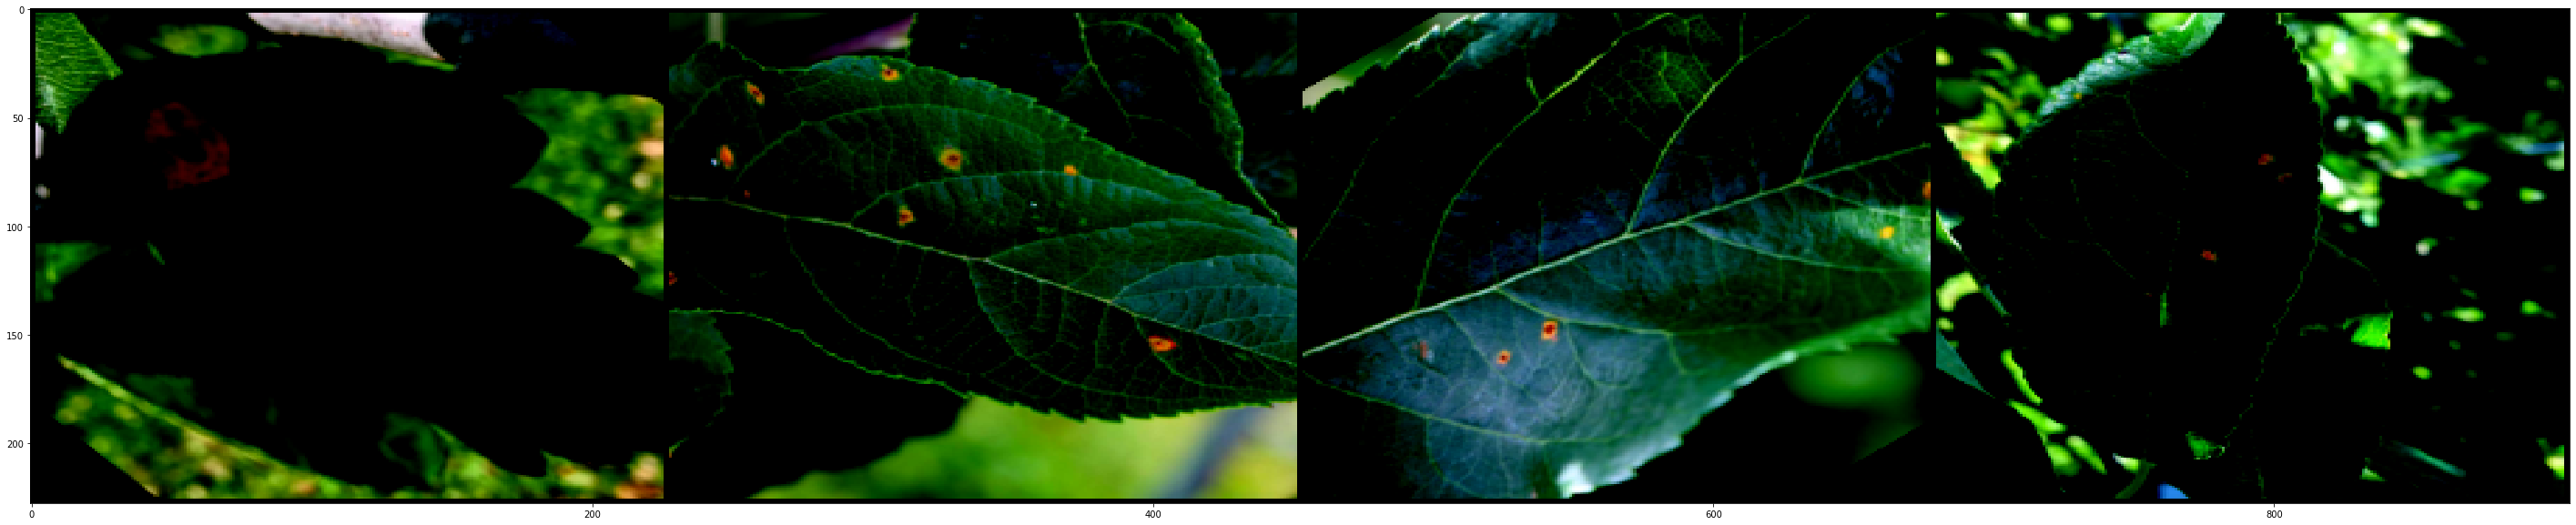

<Figure size 432x288 with 0 Axes>

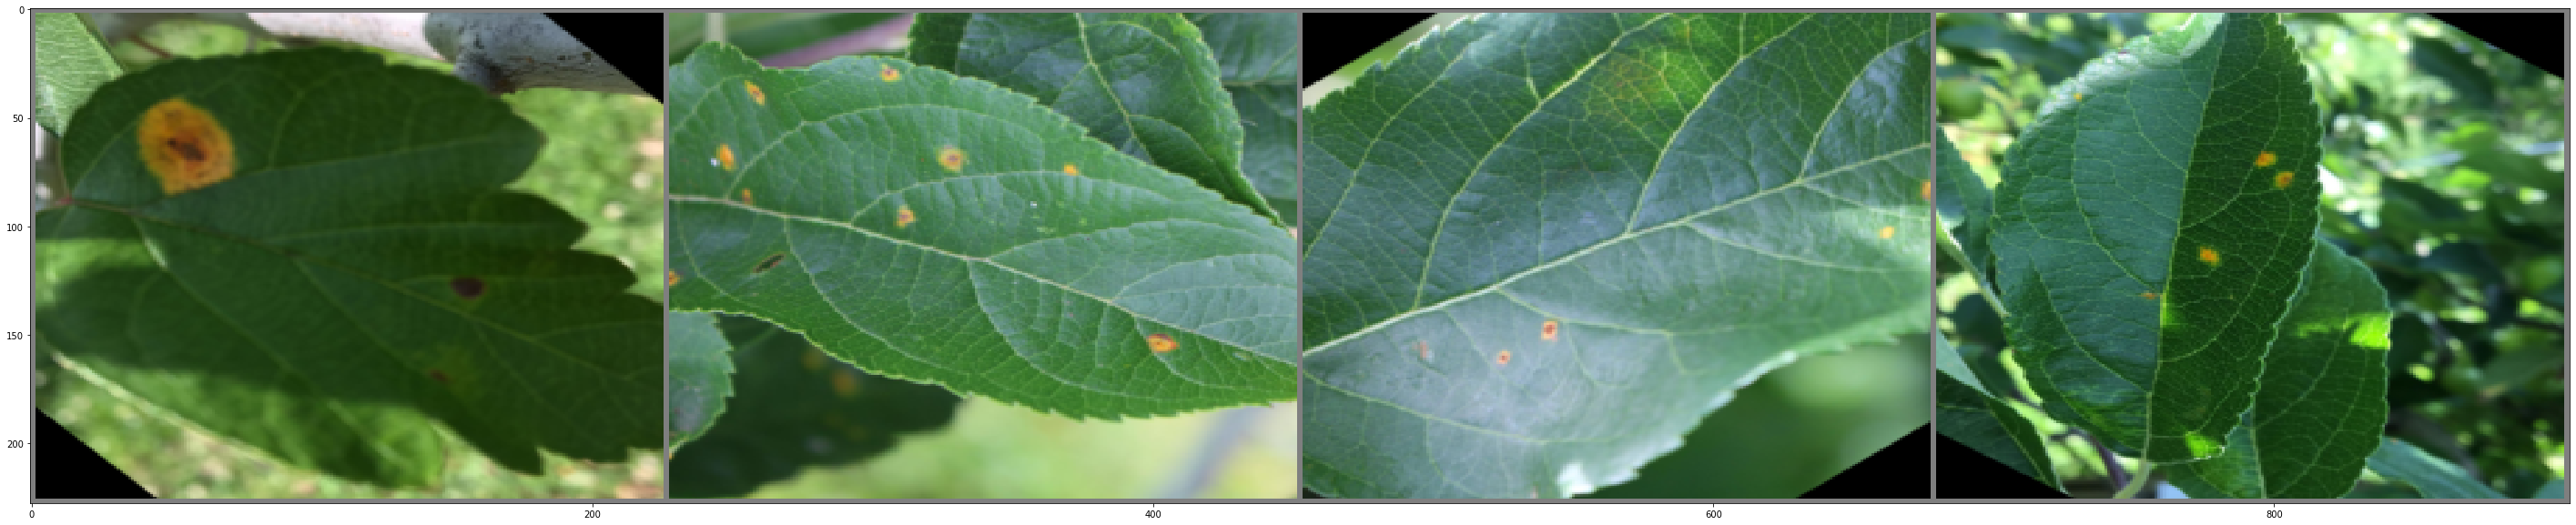

In [177]:
classes = ('healthy', 'multiple_diseases', 'rust', 'scab')
dataiter_test = iter(data_loader['train'])
#print('data_iter\n',dataiter_test)
images_test = dataiter_test.next()
images_test_data = images_test[0]
#print('image test data',images_test_data)
images_test_label = images_test[1]

for i in range(len(images_test_label)):
    print(classes[i])

def imshow(img):
    # image from transform
    #img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    fig = plt.figure()
    fig = plt.figure(figsize=(50,10))
    ax_show = fig.add_subplot(111)
    ax_show.imshow(np.transpose(npimg, (1, 2, 0)), aspect = 'auto', interpolation='none')
    plt.show()
    
    # image unormalize
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    fig = plt.figure()
    fig = plt.figure(figsize=(50,10))
    ax_show = fig.add_subplot(111)
    ax_show.imshow(np.transpose(npimg, (1, 2, 0)), aspect = 'auto', interpolation='none')
    plt.show()

# print images
imshow(torchvision.utils.make_grid(images_test_data))

# Model

In [7]:
# define the CNN architecture
class Net(nn.Module):
    ### TODO: choose an architecture, and complete the class
    def __init__(self):
        super(Net, self).__init__()
        ## Define layers of a CNN
        # CL sees 224 x 224 x 3 image tensor
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.conv11= nn.Conv2d(16, 16, 2, padding=0)
        self.conv1_1 = nn.Conv2d(16, 32, 3, padding=1)
        
        # CL sees 112 x 112 x 16
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv22 = nn.Conv2d(64, 64, 2, padding=0)
        self.conv2_1 = nn.Conv2d(64, 128, 3, padding=1)
        
        
        # CL sees 56 x 56 x 32
        self.conv3 = nn.Conv2d(128, 256, 3, padding=1)
        self.conv33 = nn.Conv2d(256, 256, 2, padding=0)
        self.conv3_1 = nn.Conv2d(256, 512, 3, padding=1)
        
        
        # CL sees 56 x 56 x 32
        #self.conv4 = nn.Conv2d(256, 512, 2, padding=0)
        #self.conv4_1 = nn.Conv2d(512, 512, 3, padding=1)
        #self.batchnorm512 = nn.BatchNorm2d(512)
        
        #batchNorm
        self.batchnorm16 = nn.BatchNorm2d(16)
        self.batchnorm32 = nn.BatchNorm2d(32)
        self.batchnorm64 = nn.BatchNorm2d(64)
        self.batchnorm128 = nn.BatchNorm2d(128)
        self.batchnorm256 = nn.BatchNorm2d(256)
        self.batchnorm512 = nn.BatchNorm2d(512)
        self.batchnorm1024 = nn.BatchNorm2d(1024)
        self.batchnorm2048 = nn.BatchNorm2d(2048)
        
        # Max pooling layer
        self.pool = nn.MaxPool2d(3, 3)
        self.AVGpool = nn.AvgPool2d(3, 3)
        
        # linear layer (64 * 28 * 28 -> 500)
        self.fc1 = nn.Linear(512 * 7 * 7, 500)
        
        # linear layer (500 -> 250)
        self.fc2 = nn.Linear(500, 250)
        
        # linear layer (250 -> 125)
        self.fc3 = nn.Linear(250, 125)
        
        # linear layer (125 -> 4)
        self.fc4 = nn.Linear(125, 4)
        
        # dropout layer (p=0.25)
        self.dropout = nn.Dropout2d(0.2)
        
        # LogSoftmax
        self.LogSM = nn.LogSoftmax()
    
    def forward(self, x):
        ## Define forward behavior
        # 1st CNN
        # 3 => 16
        x = self.conv1(x)
        x = F.relu6(x)
        x = self.conv11(x)
        x = F.relu6(x)
        x = self.batchnorm16(x)
        
        # 16 => 32
        x = self.conv1_1(x)
        x = F.relu6(x)
        x = self.batchnorm32(x)
        
        x = self.AVGpool(x)
        x = self.dropout(x)
        
        # 2nd CNN
        # 32 => 64
        x = self.conv2(x)
        x = F.relu6(x)
        x = self.conv22(x)
        x = F.relu6(x)
        x = self.batchnorm64(x)
        
        # 64 => 128
        x = self.conv2_1(x)
        x = F.relu6(x)
        x = self.batchnorm128(x)
        
        x = self.AVGpool(x)
        x = self.dropout(x)
        
        # 3rd CNN
        # 128 => 256
        x = self.conv3(x)
        x = F.relu6(x)
        x = self.conv33(x)
        x = F.relu6(x)
        x = self.batchnorm256(x)

        # 256 => 512
        x = self.conv3_1(x)
        x = F.relu6(x)
        x = self.batchnorm512(x)
        
        x = self.AVGpool(x)
        x = self.dropout(x)
        
        
        #print(x.shape)
        # flatten image input
        #print(x.shape)
        x = x.view(-1, 512 * 7 * 7)
        #x = self.dropout(x)
        
        # add 1st hidden layer, with relu activation function
        x = self.fc1(x)
        x = F.relu6(x)
        x = self.dropout(x)
        
        #h2
        x = self.fc2(x)
        x = F.relu6(x)
        x = self.dropout(x)
        
        #h3
        x = self.fc3(x)
        x = F.relu(x)
        x = self.dropout(x)
        
        #h
        x = self.LogSM(self.fc4(x))

        return x

#-#-# You do NOT have to modify the code below this line. #-#-#

# instantiate the CNN
model_patho = Net()

# move tensors to GPU if CUDA is available
if use_cuda:
    model_scratch.cuda()

    
model_patho = Net()

In [8]:
summary(Net(),input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 224, 224]             448
            Conv2d-2         [-1, 16, 223, 223]           1,040
       BatchNorm2d-3         [-1, 16, 223, 223]              32
            Conv2d-4         [-1, 32, 223, 223]           4,640
       BatchNorm2d-5         [-1, 32, 223, 223]              64
         AvgPool2d-6           [-1, 32, 74, 74]               0
         Dropout2d-7           [-1, 32, 74, 74]               0
            Conv2d-8           [-1, 64, 74, 74]          18,496
            Conv2d-9           [-1, 64, 73, 73]          16,448
      BatchNorm2d-10           [-1, 64, 73, 73]             128
           Conv2d-11          [-1, 128, 73, 73]          73,856
      BatchNorm2d-12          [-1, 128, 73, 73]             256
        AvgPool2d-13          [-1, 128, 24, 24]               0
        Dropout2d-14          [-1, 128,

C:\Users\amallet\Anaconda\envs\udacity_env\lib\site-packages\ipykernel_launcher.py:134: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


In [9]:
### TODO: select loss function
criterion = nn.CrossEntropyLoss()

### TODO: select optimizer
optimizer = optim.SGD(model_patho.parameters(), lr=0.0005)

In [10]:
def train(n_epochs, loaders, model, optimizer, criterion):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        model.train()
        for idx, (data, target) in enumerate(loaders['train']):

            ## find the loss and update the model parameters accordingly
            ## record the average training loss, using something like
            ## train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            #update training loss
            train_loss += loss.item()*data.size(0)
            
        model.eval()
        for idx, (data, target) in enumerate(loaders['valid']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## update the average validation loss
            output = model(data)
            # calculate the batch loss
            loss = criterion(output, target)
            # update average validation loss 
            valid_loss += loss.item()*data.size(0)
            
        # calculate average losses
        train_loss = train_loss/len(loaders['train'].sampler)
        valid_loss = valid_loss/len(loaders['valid'].sampler)
            
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))
        
        ## TODO: save the model if validation loss has decreased
        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min,
            valid_loss,
            torch.save(model.state_dict(), 'model_patho_16_valid_LR00005.pt'))
                 )
            valid_loss_min = valid_loss
            
    # return trained model
    return model

In [28]:
model_res = train(30, data_loader, model_patho, optimizer, criterion)



C:\Users\amallet\Anaconda\envs\udacity_env\lib\site-packages\ipykernel_launcher.py:134: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch: 1 	Training Loss: 1.350347 	Validation Loss: 1.327306
Epoch: 2 	Training Loss: 1.305530 	Validation Loss: 1.277283
Epoch: 3 	Training Loss: 1.241064 	Validation Loss: 1.191116
Epoch: 4 	Training Loss: 1.151908 	Validation Loss: 1.069549
Epoch: 5 	Training Loss: 1.053468 	Validation Loss: 0.959730
Epoch: 6 	Training Loss: 0.965604 	Validation Loss: 0.994073
Epoch: 7 	Training Loss: 0.882250 	Validation Loss: 0.798207
Epoch: 8 	Training Loss: 0.787132 	Validation Loss: 0.742042
Epoch: 9 	Training Loss: 0.723925 	Validation Loss: 0.671853
Epoch: 10 	Training Loss: 0.687458 	Validation Loss: 0.630190
Epoch: 11 	Training Loss: 0.647422 	Validation Loss: 0.623749
Epoch: 12 	Training Loss: 0.606648 	Validation Loss: 0.515256
Epoch: 13 	Training Loss: 0.584620 	Validation Loss: 0.508382
Epoch: 14 	Training Loss: 0.562437 	Validation Loss: 0.413717
Epoch: 15 	Training Loss: 0.524782 	Validation Loss: 0.394885
Epoch: 16 	Training Loss: 0.501954 	Validation Loss: 0.451829
Epoch: 17 	Traini

In [11]:
model_res = Net()

# load the model that got the best validation accuracy
model_res.load_state_dict(torch.load('model_patho_16_valid_LR0005.pt'))

<All keys matched successfully>

# TEST

In [33]:
class CustomDataset_test(Dataset):
    def __init__(self, csv_file, id_col, target_col, root_dir, sufix=None, transform=None):
        """
        Args:
            csv_file   (string):             Path to the csv file with annotations.
            root_dir   (string):             Directory with all the images.
            id_col     (string):             csv id column name.
            target_col (string):             csv target column name.
            sufix      (string, optional):   Optional sufix for samples.
            transform  (callable, optional): Optional transform to be applied on a sample.
        """
        self.data      = pd.read_csv(csv_file)
        self.id        = id_col
        self.target    = target_col
        self.root      = root_dir
        self.sufix     = sufix
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # get the image name at the different idx
        img_name = self.data.loc[idx, self.id]
        
        # if there is not sufic, nothing happened. in this case sufix is '.jpg'
        if self.sufix is not None:
            img_name = img_name + self.sufix
        
        # it opens the image of the img_name at the specific idx
        image = Image.open(os.path.join(self.root, img_name))
        
        # if there is not transform nothing happens, here we defined below two transforms for train and for test
        if self.transform is not None:
            image = self.transform(image)
        
        label = self.data.loc[idx, self.id]
        label = int(label[5:])
        label = torch.tensor(label)
        
        return image, label

data_transforms_test = {
    'train': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
    ])
}

params = {
    'id_col':     'image_id',  
    'target_col': ['healthy', 'multiple_diseases', 'rust', 'scab'],
    'sufix':      '.jpg',
    'transform':  data_transforms_test['test']
}

test_dataset = CustomDataset_test(csv_file=data_dir+'test.csv', root_dir=data_dir+'images', **params)
test_loader = DataLoader(test_dataset, batch_size = 4, shuffle=True)

In [34]:
print('TRAINING')
img_test, lab_test = test_dataset.__getitem__(0)

print('DATASET TEST')
print('image at the first row: {}', img_test.shape)
print('image size at the first row: {}'.format(img_test.size()))
print('Lab at the first row: ', lab_test)
print('lab format at the first row: {}'.format(lab_test))
print('lab format at the first row: {}'.format(lab_test.shape))

print()
print('Train Loader type')
test_iter = iter(test_loader)
print(type(test_iter))


images_test, labels_test = train_iter.next()
print()
print('DATALOADER TEST')
print('images test',images_test[0][0][0][0])
print('images type on batch size = {}'.format(type(images_test)))
print('images shape on batch size = {}', images_test.shape)
print('labels type on batch size = {}'.format(type(labels_test)))
print('labels shape on batch size = {}', labels_test)

TRAINING
DATASET TEST
image at the first row: {} torch.Size([3, 224, 224])
image size at the first row: torch.Size([3, 224, 224])
Lab at the first row:  tensor(0)
lab format at the first row: 0
lab format at the first row: torch.Size([])

Train Loader type
<class 'torch.utils.data.dataloader._SingleProcessDataLoaderIter'>

DATALOADER TEST
images test tensor(0.1768)
images type on batch size = <class 'torch.Tensor'>
images shape on batch size = {} torch.Size([16, 3, 224, 224])
labels type on batch size = <class 'torch.Tensor'>
labels shape on batch size = {} tensor([2, 0, 2, 0, 3, 0, 2, 3, 2, 2, 3, 3, 3, 0, 0, 3])


data_iter
image test data tensor([[[[0.3176, 0.3333, 0.4431,  ..., 0.1804, 0.1686, 0.1647],
          [0.3333, 0.3725, 0.5020,  ..., 0.1686, 0.1647, 0.1569],
          [0.3647, 0.4392, 0.5647,  ..., 0.1647, 0.1608, 0.1529],
          ...,
          [0.4667, 0.5059, 0.5333,  ..., 0.7020, 0.7294, 0.7490],
          [0.4706, 0.4863, 0.4941,  ..., 0.6275, 0.6627, 0.6824],
          [0.4627, 0.4627, 0.4588,  ..., 0.5176, 0.5529, 0.5843]],

         [[0.4235, 0.4431, 0.5686,  ..., 0.2784, 0.2667, 0.2627],
          [0.4353, 0.4902, 0.6353,  ..., 0.2627, 0.2588, 0.2549],
          [0.4706, 0.5647, 0.6980,  ..., 0.2667, 0.2627, 0.2549],
          ...,
          [0.5765, 0.6000, 0.6196,  ..., 0.8235, 0.8431, 0.8510],
          [0.5765, 0.5843, 0.5882,  ..., 0.7569, 0.7882, 0.7961],
          [0.5647, 0.5647, 0.5608,  ..., 0.6549, 0.6941, 0.7098]],

         [[0.2235, 0.2392, 0.3412,  ..., 0.1608, 0.1490, 0.1412],
          [0.2471, 0.2980, 0.4118,  ..., 0.1451, 0.1412, 0.1255],
          [0.286

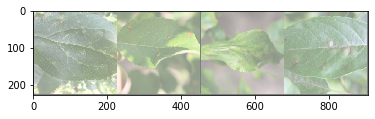

In [35]:
classes = ('healthy', 'multiple_diseases', 'rust', 'scab')

dataiter_test = iter(test_loader)
print('data_iter\n',dataiter_test)
images_test = dataiter_test.next()
images_test_data = images_test[0]
print('image test data',images_test_data)
images_test_label = images_test[1]
print(images_test_label)

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# print images
imshow(torchvision.utils.make_grid(images_test_data))
#print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [41]:
model_test = Net()
model_test.load_state_dict(torch.load('model_patho_16_valid_LR0005.pt'))
model_test = model_test.eval()

out_fwd = model_test.forward(images_test_data)
print('Result preditcion model on dataset:\n {}\n'.format(out_fwd))
probs = torch.exp(out_fwd)
print('probs\n', probs)
top_probs, top_labs = probs.topk(4)
print('top_probs:\n {} \n top_labs:\n {}'.format(top_probs, top_labs))
print(classes[top_labs[0][0].detach().numpy()])
print(classes[top_labs[1][0].detach().numpy()])
print(classes[top_labs[2][0].detach().numpy()])
print(classes[top_labs[3][0].detach().numpy()])


Result preditcion model on dataset:
 tensor([[-0.0736, -5.1203, -3.7987, -3.1563],
        [-0.0790, -5.0043, -3.6392, -3.1475],
        [-0.0665, -5.1774, -3.7612, -3.3408],
        [-0.0436, -5.7220, -4.8529, -3.4539]], grad_fn=<LogSoftmaxBackward>)

probs
 tensor([[0.9290, 0.0060, 0.0224, 0.0426],
        [0.9241, 0.0067, 0.0263, 0.0430],
        [0.9357, 0.0056, 0.0233, 0.0354],
        [0.9573, 0.0033, 0.0078, 0.0316]], grad_fn=<ExpBackward>)
top_probs:
 tensor([[0.9290, 0.0426, 0.0224, 0.0060],
        [0.9241, 0.0430, 0.0263, 0.0067],
        [0.9357, 0.0354, 0.0233, 0.0056],
        [0.9573, 0.0316, 0.0078, 0.0033]], grad_fn=<TopkBackward>) 
 top_labs:
 tensor([[0, 3, 2, 1],
        [0, 3, 2, 1],
        [0, 3, 2, 1],
        [0, 3, 2, 1]])
healthy
healthy
healthy
healthy


C:\Users\amallet\Anaconda\envs\udacity_env\lib\site-packages\ipykernel_launcher.py:134: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


In [30]:
plok, predicted = torch.max(outputs_test, 1)

print(plok)
print(predicted)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]] for j in range(4)))

tensor([-0.0405, -0.1276, -0.0981, -0.0562], grad_fn=<MaxBackward0>)
tensor([0, 0, 0, 0])
Predicted:  healthy healthy healthy healthy


# Submission

In [42]:
submission_df = pd.read_csv(data_dir + 'sample_submission.csv')

submission_df.iloc[:, 1:] = 0

submission_df.head()

,image_id,healthy,multiple_diseases,rust,scab
0,Test_0,0,0,0,0
1,Test_1,0,0,0,0
2,Test_2,0,0,0,0
3,Test_3,0,0,0,0
4,Test_4,0,0,0,0


In [43]:
submission_df_test = pd.read_csv(data_dir + 'sample_submission.csv')

model_test = Net()
model_test.load_state_dict(torch.load('model_patho_16_valid_LR0005.pt'))
model_test = model_test.eval()

batch_size = 4

for data in enumerate(test_loader):
    images_data = data[1][0]
    #print(images_data)
    label_data = data[1][1]
    #print(label_data)   
    probs = torch.exp(model_test(images_data))
    #print(probs)
    label_data = label_data.numpy()
    #print(label_data)
    probs = probs.detach().numpy()
    #print(probs)
    for i in range(len(label_data)):
        print(i)
        ind = label_data[i]
        print(ind)
        res_probs = probs[i]
        print(res_probs)
        res_add = ['Test_'+str(ind), res_probs[0], res_probs[1],res_probs[2],res_probs[3]]
        submission_df_test.loc[ind] = res_add         
        
pd.set_option("display.max_rows", 10, "display.max_columns", None)
print(submission_df_test)
submission_df_test.to_csv(path_or_buf='sample_submission_2.csv', index=False)


C:\Users\amallet\Anaconda\envs\udacity_env\lib\site-packages\ipykernel_launcher.py:134: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


0
1101
[0.9511974  0.00349476 0.007442   0.03786593]
1
706
[0.9830277  0.00123994 0.00220427 0.01352813]
2
837
[0.9024135  0.00893334 0.03999834 0.04865495]
3
1016
[0.9563298  0.00344468 0.00908851 0.03113699]
0
75
[0.84037507 0.00913705 0.0071103  0.14337753]
1
894
[0.9766827  0.00169037 0.00360076 0.01802613]
2
950
[0.9742475  0.00175284 0.00272493 0.02127469]
3
1319
[0.9139377  0.00644664 0.01529176 0.06432386]
0
547
[0.9625604  0.00320946 0.01273032 0.02149991]
1
848
[0.94736975 0.00439881 0.01385194 0.03437947]
2
965
[0.97416544 0.00185918 0.00388618 0.0200892 ]
3
839
[0.9542851  0.00360811 0.00854962 0.03355717]
0
945
[9.8730308e-01 9.4439252e-04 2.1597773e-03 9.5926551e-03]
1
1003
[0.9656348  0.00233249 0.00437184 0.02766079]
2
329
[0.87681496 0.01027948 0.02693493 0.08597062]
3
1311
[0.98119915 0.00112876 0.0016784  0.01599369]
0
1070
[0.9690363  0.00306964 0.01260565 0.01528842]
1
522
[0.90824807 0.00627377 0.01072369 0.07475455]
2
35
[0.8983805  0.00834698 0.02382211 0.069450

0
1388
[0.9228604  0.00622516 0.01822072 0.05269376]
1
1515
[0.91563624 0.0057746  0.009757   0.06883211]
2
951
[0.90483993 0.00666056 0.01258906 0.07591042]
3
691
[0.9682344  0.00267802 0.01028474 0.01880281]
0
1048
[0.95927316 0.00255119 0.00339636 0.03477934]
1
1710
[0.9675425  0.00212948 0.00328232 0.02704559]
2
1490
[0.9195812  0.00700853 0.02476085 0.04864945]
3
37
[0.9510557  0.00316481 0.00411079 0.04166867]
0
1065
[0.92128897 0.00683797 0.02863671 0.04323632]
1
591
[0.8723521  0.0108327  0.02940759 0.08740753]
2
252
[0.94173616 0.00363184 0.00584837 0.04878367]
3
1714
[0.9759005  0.00191239 0.00520585 0.01698139]
0
583
[0.9779635  0.00163317 0.00331161 0.01709163]
1
518
[0.9304925  0.00476591 0.00811704 0.05662443]
2
321
[0.9836728  0.00111622 0.0021164  0.01309469]
3
1582
[0.7792922  0.01159061 0.00900102 0.20011616]
0
347
[0.92470145 0.00493833 0.00661907 0.06374113]
1
1236
[0.9272558  0.00582195 0.01456858 0.05235367]
2
1505
[0.9501055  0.00394488 0.00991063 0.03603901]
3
7

0
1649
[0.918411   0.00660155 0.01746214 0.05752535]
1
1287
[0.9675003  0.0018677  0.00215693 0.02847512]
2
190
[0.91045785 0.00665539 0.01449356 0.06839319]
3
476
[0.88026184 0.01089718 0.04364631 0.06519464]
0
1663
[0.83498836 0.00760537 0.00562565 0.15178072]
1
1548
[0.9799544  0.0017147  0.00563557 0.01269522]
2
1164
[0.9469947  0.00425214 0.01169709 0.03705613]
3
1266
[0.9247845  0.00641996 0.01983449 0.04896104]
0
857
[0.9220953  0.00693719 0.03541406 0.03555341]
1
875
[0.96074957 0.00303921 0.00824645 0.0279648 ]
2
1181
[0.9388008  0.00359388 0.00457232 0.05303297]
3
1773
[0.9122065  0.00781759 0.03134733 0.04862856]
0
865
[0.9735069  0.00200551 0.00331318 0.02117441]
1
204
[0.94474006 0.00385861 0.00782973 0.04357155]
2
754
[0.9681169  0.00157059 0.0013551  0.02895739]
3
1675
[0.9410452  0.00543484 0.01990902 0.03361089]
0
514
[0.9569149  0.00346502 0.01085924 0.02876093]
1
1318
[0.9829811  0.00138506 0.00259528 0.0130386 ]
2
1698
[0.95243406 0.00387119 0.01246583 0.03122891]
3

0
1091
[0.96688586 0.00270862 0.01006574 0.02033975]
1
450
[0.9796338  0.00165892 0.00568216 0.01302525]
2
1261
[0.92479944 0.0060868  0.01751607 0.05159756]
3
709
[0.7745949  0.01455635 0.02060187 0.19024695]
0
248
[0.97100633 0.00229852 0.00537421 0.02132098]
1
1131
[0.9525565  0.00407827 0.01852367 0.0248415 ]
2
820
[0.9270136  0.00646609 0.02317649 0.04334377]
3
20
[0.939056   0.00523036 0.02294642 0.03276714]
0
542
[0.9774714  0.00168356 0.00432272 0.01652236]
1
507
[0.8648993  0.01171464 0.03301305 0.09037299]
2
1242
[0.9281748  0.00633879 0.03024531 0.03524121]
3
657
[0.9281524  0.00480021 0.00731985 0.05972745]
0
162
[0.92186457 0.00665059 0.02246363 0.0490212 ]
1
1597
[0.9237799  0.00589791 0.01507096 0.05525121]
2
1660
[0.91482115 0.00768248 0.03202356 0.04547287]
3
1312
[0.9804883  0.00152062 0.00402535 0.01396568]
0
1639
[0.97594833 0.00182396 0.00404509 0.01818258]
1
768
[0.89228344 0.00963448 0.03810907 0.05997302]
2
1492
[0.9266436  0.0058454  0.01762801 0.04988296]
3
11

0
1461
[0.9135092  0.00725674 0.02297522 0.05625873]
1
1182
[0.9394116  0.00526214 0.01812098 0.03720532]
2
715
[0.93502724 0.00483331 0.01018229 0.04995713]
3
1689
[0.94367254 0.00486155 0.02011601 0.0313499 ]
0
758
[0.9731068  0.00188004 0.00391813 0.021095  ]
1
222
[0.88487065 0.01023526 0.03386803 0.07102606]
2
80
[0.7870136  0.00781297 0.00392669 0.20124666]
3
1760
[0.95111233 0.00273158 0.00271147 0.04344461]
0
1394
[0.9699019  0.00205228 0.00353537 0.02451045]
1
189
[0.9815283  0.00143176 0.00362466 0.01341526]
2
552
[0.759479   0.01486164 0.02158346 0.20407595]
3
320
[0.974408   0.00187094 0.00436849 0.01935257]
0
405
[0.90532935 0.00831412 0.02991764 0.05643892]
1
46
[0.9685961  0.00233848 0.00653694 0.02252842]
2
1157
[0.95392257 0.00330282 0.00658919 0.03618553]
3
276
[0.9462403  0.0025957  0.00214161 0.04902237]
0
1290
[0.9737464  0.00203891 0.00527057 0.01894407]
1
1674
[0.91672564 0.00714387 0.02535141 0.05077909]
2
958
[0.891971   0.00660122 0.00741935 0.09400841]
3
361


0
168
[0.91040343 0.00818033 0.03963425 0.04178196]
1
191
[0.9493827  0.00397481 0.01083028 0.0358122 ]
2
1522
[0.88252264 0.00553799 0.00480599 0.1071334 ]
3
294
[0.86454844 0.01184248 0.03950689 0.08410222]
0
69
[0.9493027  0.0032681  0.00570403 0.0417252 ]
1
638
[0.8871077  0.00986676 0.01339708 0.08962847]
2
1275
[0.9095111  0.00637851 0.01061109 0.07349941]
3
799
[0.81946635 0.01011648 0.01242253 0.15799475]
0
829
[0.9630638  0.00235584 0.00368624 0.0308942 ]
1
535
[0.9472315  0.00387618 0.00775482 0.04113759]
2
1580
[0.98599863 0.00099509 0.00222257 0.01078369]
3
605
[0.9463773  0.004305   0.0132884  0.03602934]
0
175
[0.94702584 0.0046031  0.01672525 0.03164576]
1
1805
[0.93907934 0.00521972 0.02313622 0.03256471]
2
1299
[0.7510648  0.0139024  0.01424426 0.22078858]
3
966
[0.9179482  0.00617992 0.01195143 0.06392048]
0
6
[0.93688655 0.00539343 0.01811337 0.03960662]
1
983
[0.8494588  0.01171059 0.02500672 0.11382394]
2
1614
[0.8522609  0.01363861 0.05563364 0.07846682]
3
199
[0.

0
506
[0.8964755  0.00856824 0.02157877 0.07337748]
1
38
[0.9610747  0.00291853 0.00384826 0.03215849]
2
705
[0.8833404  0.00880139 0.01663739 0.0912208 ]
3
1621
[0.96857417 0.00253407 0.0080861  0.0208056 ]
0
48
[0.91867936 0.00579283 0.01221166 0.06331622]
1
1291
[0.94542474 0.00404818 0.00947261 0.04105447]
2
893
[0.93858385 0.00530252 0.02301965 0.03309404]
3
751
[0.9203149  0.00456329 0.00505128 0.07007051]
0
1682
[0.5673045  0.01568896 0.00739501 0.4096116 ]
1
1562
[0.97765505 0.00152854 0.00265215 0.01816436]
2
861
[0.952852   0.00381425 0.01170284 0.03163094]
3
858
[0.9360894  0.00455909 0.00878754 0.05056402]
0
1152
[0.95936006 0.00305025 0.00801    0.02957967]
1
1558
[0.95809144 0.00330508 0.00911414 0.02948933]
2
1797
[0.9224445  0.00690964 0.02484827 0.04579762]
3
510
[0.8022538  0.0098409  0.00983838 0.17806694]
0
1352
[0.84148943 0.01333765 0.03278115 0.11239183]
1
979
[0.97108704 0.00234285 0.00691005 0.01966005]
2
660
[0.9754421  0.00162302 0.00286254 0.02007232]
3
348


0
349
[0.90727204 0.00778137 0.01650583 0.0684408 ]
1
1748
[0.83013314 0.00911938 0.00809407 0.15265337]
2
500
[0.9422474  0.00445366 0.0086108  0.04468808]
3
311
[0.67808026 0.0129479  0.00562348 0.3033484 ]
0
878
[9.8660594e-01 9.6944807e-04 1.8809988e-03 1.0543581e-02]
1
539
[0.76307833 0.01294269 0.0141618  0.20981722]
2
1471
[0.90197974 0.0071215  0.01445819 0.07644052]
3
935
[0.64565843 0.01686059 0.01129021 0.3261908 ]
0
627
[0.9619394  0.00318832 0.01208608 0.02278617]
1
166
[0.98281026 0.00126553 0.00261506 0.01330912]
2
1733
[0.97014767 0.00235728 0.00218264 0.02531236]
3
17
[0.9494335  0.00377577 0.00812962 0.03866114]
0
1279
[0.92621326 0.00649594 0.0315427  0.03574808]
1
912
[0.89937276 0.0075738  0.01606386 0.07698965]
2
1687
[0.9657791  0.00274484 0.00587279 0.02560332]
3
127
[0.9096438  0.00788419 0.03236593 0.05010599]
0
720
[0.97776866 0.00155453 0.00339743 0.01727929]
1
1104
[0.9457405  0.00450353 0.01656942 0.03318641]
2
485
[0.93043226 0.00564928 0.01277438 0.05114

0
1798
[0.97640204 0.00190281 0.00620966 0.01548544]
1
652
[0.96161366 0.00297829 0.00876161 0.02664639]
2
781
[0.9841245  0.0010742  0.00204575 0.01275559]
3
1564
[0.5823382  0.01362042 0.00618023 0.39786106]
0
1310
[0.9489763  0.00371151 0.00754811 0.03976408]
1
1525
[0.9600803  0.00337005 0.01065481 0.02589475]
2
1301
[0.91084856 0.00668344 0.01204557 0.07042246]
3
993
[0.94678086 0.00349215 0.00529686 0.04443007]
0
952
[0.9671901  0.00241731 0.00603923 0.02435342]
1
1811
[0.9632718  0.00264365 0.00541425 0.02867029]
2
832
[0.98084956 0.00144097 0.00292841 0.01478103]
3
1237
[0.953656   0.00380074 0.00967337 0.03286991]
0
1818
[0.97851825 0.00158709 0.00408196 0.01581267]
1
1254
[0.95796245 0.00358148 0.01845065 0.02000541]
2
256
[0.97923195 0.00165228 0.00422412 0.01489168]
3
516
[0.9318517  0.00489653 0.00987625 0.05337552]
0
1180
[0.94047636 0.00505723 0.01778595 0.03668051]
1
1002
[0.964647   0.00252555 0.00449109 0.02833633]
2
1098
[0.9439137  0.00467896 0.0155355  0.03587181]


0
1139
[0.8903863  0.00991719 0.0476236  0.05207285]
1
140
[0.87123966 0.01079292 0.03140667 0.0865608 ]
2
327
[0.9369613  0.00524962 0.01682267 0.04096637]
3
1007
[0.92105734 0.00702485 0.03052198 0.04139596]
0
623
[0.9526884  0.00374591 0.01253203 0.03103369]
1
477
[0.9277732  0.00638619 0.02361308 0.04222758]
2
986
[0.9074195  0.00827551 0.03692232 0.04738258]
3
486
[0.9737815  0.00208362 0.00406298 0.02007196]
0
1507
[0.98044306 0.00144213 0.00242881 0.01568599]
1
1813
[0.9534594  0.00392229 0.01359936 0.02901897]
2
812
[0.89012754 0.00666659 0.00948015 0.09372585]
3
1479
[0.94513404 0.00480545 0.02584442 0.02421614]
0
1001
[0.9750474  0.00197814 0.00441902 0.01855548]
1
735
[0.9607892  0.00323511 0.00915959 0.0268161 ]
2
1194
[0.94896847 0.00418714 0.01336723 0.03347728]
3
619
[0.9695146  0.00226858 0.00537589 0.02284092]
0
1058
[0.98220533 0.00121385 0.00251246 0.01406836]
1
451
[0.87902653 0.00671368 0.00630367 0.10795618]
2
1503
[0.97042817 0.00255247 0.01188915 0.01513017]
3
7

0
1145
[0.9420031  0.00503661 0.02025388 0.03270657]
1
1563
[0.9066932  0.00820802 0.03459191 0.05050673]
2
1416
[0.9837144  0.00105033 0.00158283 0.0136523 ]
3
864
[0.88949883 0.00897357 0.02242982 0.07909781]
0
1684
[0.97791946 0.00152629 0.00296074 0.01759345]
1
1567
[0.8434402  0.01166699 0.02177836 0.12311456]
2
1066
[0.9597021  0.00345702 0.0113281  0.02551285]
3
718
[0.9614293  0.00264671 0.00457111 0.03135285]
0
19
[0.8894742  0.0099211  0.03613082 0.06447386]
1
934
[0.9677635  0.0033445  0.00573056 0.02316139]
2
316
[0.9206613  0.00706833 0.02166248 0.05060792]
3
543
[0.92904836 0.00570395 0.01298516 0.05226264]
0
1643
[0.9499881  0.00471938 0.01858914 0.02670345]
1
369
[0.95577717 0.00339019 0.00849297 0.03233954]
2
383
[0.9237914  0.00668725 0.0243032  0.04521825]
3
953
[0.8766915  0.01073012 0.03450637 0.07807197]
0
1598
[0.96141857 0.00316756 0.01127139 0.02414235]
1
1198
[0.9235115  0.00663787 0.02683466 0.04301602]
2
88
[0.9718428  0.00161906 0.00200022 0.02453799]
3
272

0
422
[0.9439863  0.00496283 0.02553709 0.0255138 ]
1
426
[0.89421684 0.00798787 0.01799455 0.07980073]
2
337
[0.9799258  0.0014752  0.00187445 0.01672455]
3
675
[9.8650682e-01 9.3923294e-04 1.7198789e-03 1.0833985e-02]
0
1089
[0.95767397 0.00312119 0.00762405 0.0315807 ]
1
1782
[0.9307004  0.00580931 0.0182263  0.04526388]
2
1138
[0.9834161  0.00111126 0.00199164 0.01348106]
3
936
[0.95758224 0.00344426 0.0126361  0.02633738]
0
1795
[0.9609134  0.00339256 0.01419767 0.02149637]
1
1201
[0.9585521  0.00321489 0.00856227 0.02967073]
2
787
[0.9089035  0.00808193 0.03049122 0.05252343]
3
1502
[0.9621723  0.00332038 0.01303961 0.02146773]
0
1053
[0.9647074  0.00261151 0.00603142 0.02664977]
1
133
[0.8799377  0.01087044 0.04468899 0.06450289]
2
780
[0.97601193 0.00177526 0.00507991 0.01713289]
3
931
[0.9401484  0.00502157 0.01894801 0.03588193]
0
1026
[0.98336446 0.00125605 0.00277983 0.01259965]
1
679
[0.97573984 0.00168476 0.00332498 0.01925047]
2
1231
[0.9512705  0.00431601 0.0198109  0.0